# Comparaison gains PINNs/PINNs+Corr et FEM/PINNs+Corr

In [1]:
# sélection du cas test
testcase = 4
version = 1
degree = 3
n_params = 50

In [ ]:
assert testcase == 4 and version == 1

**Idée :** On se place ici dans un des cas tests proposés : TestCase1,1_v2,2.

On cherche à vérifier les gains obtenues pour

- PINNs vs PINNs + Correction par addition
- FEM vs PINNs + Correction par addition

On choisira d'effectuer ces comparaisons sur 2 tailles de grilles fixées (20x20 et 40x40) en sélectionnant 50 paramètres aléatoires.

## Imports + Load

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os
import dolfin as df
import seaborn as sns
import dataframe_image as dfi

from modules.fenics_expressions import UexExpr
from scimba.equations.domain import SpaceTensor
from modules.solver_fem_4_donut_good import FEMSolver
from modules.utils import create_tree

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


Using device: cuda
cuda devices:        1
cuda current device: 0
cuda device name:    NVIDIA RTX 2000 Ada Generation Laptop GPU


In [4]:
from modules.testcases.d2.test_4.test_4_v1 import Run_laplacian2D,Poisson_2D
from modules.problem import TestCase4
problem = TestCase4(v=version)

dim_params = problem.nb_parameters
result_dir = "../../../results/2D/testcase"+str(testcase)+"/version"+str(version)
result_dir += "/facteurs/"
create_tree(result_dir)
tab_nb_vert = [20,40]
tab_h = []
for nb_vert in tab_nb_vert:
    solver = FEMSolver(nb_cell=nb_vert-1, params=[[]], problem=problem, degree=degree)
    tab_h.append(np.round(solver.mesh.hmax(),2))

torch loaded; device is cuda
hmax =  0.13314799984383346
hmax =  0.06893171898161234


2
[[-0.5, 0.500001], [-0.5, 0.500001]]
[[-0.5, 0.500001], [-0.5, 0.500001]]
>> load network /home/flecourtier/Bureau/Article1/code/networks/test_fe4_v7.pth
jsbdbshd
network loaded
Error  tensor([0.0006])


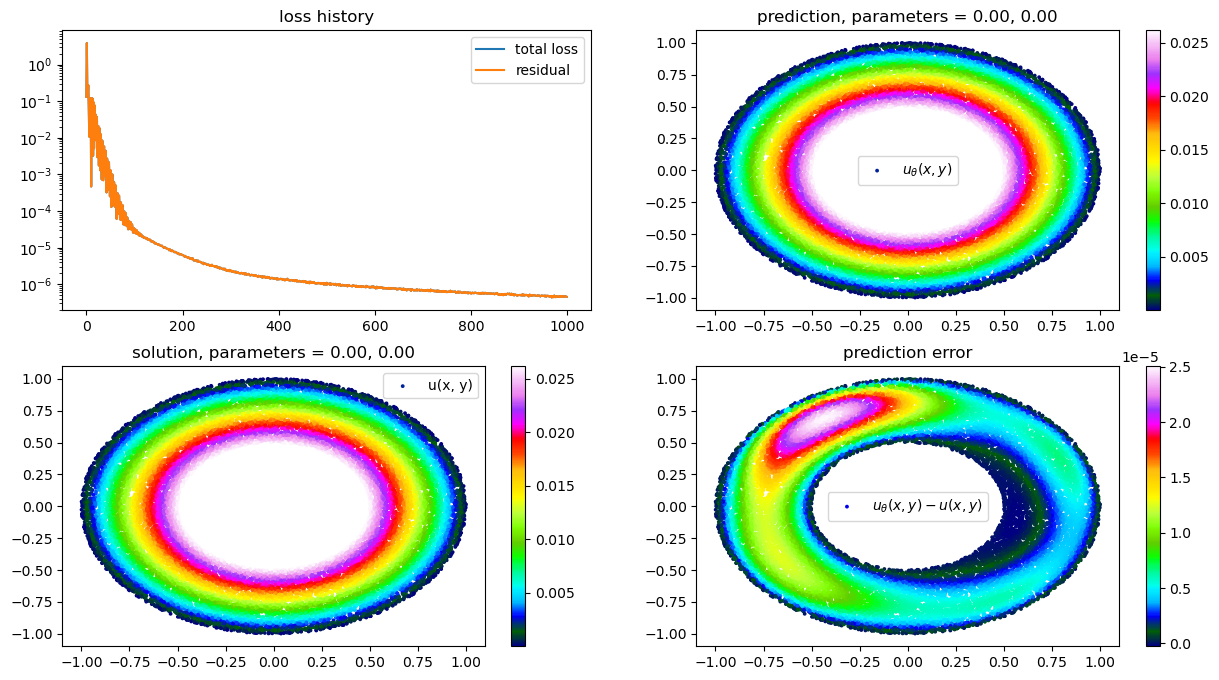

In [5]:
pde = Poisson_2D()
trainer,u_theta = Run_laplacian2D(pde)

In [6]:
def get_params(n):
    parameter_domain = trainer.pde.parameter_domain.cpu().numpy()
    # pick n random parameters for each dimension
    params = []
    for i in range(dim_params):
        parami = np.random.uniform(parameter_domain[i][0], parameter_domain[i][1], n)
        params.append(parami)
    params = np.array(params).T
    return params

np.random.seed(0)
params = get_params(n_params)
params_str = np.array([f"{params[i][0].round(2)},{params[i][1].round(2)}" for i in range(n_params)])

## Erreurs FEM

In [7]:
def read_csv_FEM(testcase,degree):
    df_FEM = pd.read_csv(result_dir+f'FEM_case{testcase}_degree{degree}.csv')
    tab_err_FEM = df_FEM.values[2:,1:]
    return tab_err_FEM

def run_FEM(degree,new_run=False):
    csv_file = result_dir+f'FEM_case{testcase}_degree{degree}.csv'
    col_names = [("FEM",str(tab_nb_vert[i]),tab_h[i]) for i in range(len(tab_nb_vert))]
    mi = pd.MultiIndex.from_tuples(col_names, names=["method","n_vert","h"])
        
    if not new_run and os.path.exists(csv_file):
        tab_err_FEM = read_csv_FEM(testcase,degree)
        df_FEM = pd.DataFrame(tab_err_FEM,columns=mi)
        print(f"Read csv file {csv_file}")
    else:
        tab_err_FEM = np.zeros((n_params,len(tab_nb_vert)))
        for (j,nb_vert) in enumerate(tab_nb_vert):
            print(f"nb_vert={nb_vert}")
            solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree)
            print("param =",end=" ")
            for i in range(n_params):
                print(i,end=" ")
                _,norme_L2 = solver.fem(i)
                tab_err_FEM[i,j] = norme_L2
            print()
        
        df_FEM = pd.DataFrame(tab_err_FEM,columns=mi)
        df_FEM.to_csv(csv_file)
           
    return df_FEM, tab_err_FEM

In [8]:
df_FEM, tab_err_FEM = run_FEM(degree)

nb_vert=20
hmax =  0.13314799984383346
param = 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 
nb_vert=40
hmax =  0.06893171898161234
param = 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 


In [9]:
df_FEM

method           FEM              
n_vert            20            40
h               0.13          0.07
0       9.020166e-07  5.999763e-08
1       9.235345e-07  6.096069e-08
2       9.483138e-07  6.512643e-08
3       9.458278e-07  6.282884e-08
4       9.172026e-07  6.117634e-08
5       9.468967e-07  6.251342e-08
6       9.026320e-07  6.034003e-08
7       9.810706e-07  6.429513e-08
8       9.761414e-07  6.457044e-08
9       9.110056e-07  6.087193e-08
10      9.741164e-07  6.397590e-08
11      9.424129e-07  6.263862e-08
12      9.065061e-07  6.052396e-08
13      1.011315e-06  6.624347e-08
14      9.333601e-07  6.398681e-08
15      9.187365e-07  6.269031e-08
16      9.777488e-07  6.686055e-08
17      9.965507e-07  6.544770e-08
18      9.424045e-07  6.420756e-08
19      1.005914e-06  6.600209e-08
20      9.948233e-07  6.980369e-08
21      9.369907e-07  6.188464e-08
22      9.475496e-07  6.460639e-08
23      9.302718e-07  6.197876e-08
24      9.421596e-07  6.395188e-08
25      9.727947e-07  6.445779e-08
26      9.163534e-07  6.229745e-08
27      1.020484e-06  6.684279e-08
28      9.120715e-07  6.045550e-08
29      9.323089e-07  6.235479e-08
30      9.049513e-07  6.088677e-08
31      9.356436e-07  6.165565e-08
32      9.462723e-07  6.324287e-08
33      9.088281e-07  6.080432e-08
34      9.377011e-07  6.423194e-08
35      9.260222e-07  6.113557e-08
36      9.070015e-07  6.015862e-08
37      9.565360e-07  6.333339e-08
38      9.658275e-07  6.442990e-08
39      9.428284e-07  6.459517e-08
40      9.029813e-07  6.036575e-08
41      9.037491e-07  6.044586e-08
42      9.611704e-07  6.336040e-08
43      9.492073e-07  6.470541e-08
44      9.297827e-07  6.127234e-08
45      9.466912e-07  6.241415e-08
46      9.101759e-07  6.137319e-08
47      9.574591e-07  6.566407e-08
48      9.305502e-07  6.275950e-08
49      9.556297e-07  6.439115e-08

## Erreurs PINNs

In [10]:
def get_test_sample(i,V_test,trainer):
    # get coordinates of the dof
    XXYY = V_test.tabulate_dof_coordinates()
    X_test = torch.tensor(XXYY,requires_grad=True)
    X_test = SpaceTensor(X_test,torch.zeros_like(X_test,dtype=int))

    # get parameters
    nb_params = len(trainer.pde.parameter_domain)
    shape = (XXYY.shape[0],nb_params)
    ones = torch.ones(shape)
    mu_test = (torch.Tensor(params[i]).to(device) * ones).to(device)

    return X_test,mu_test

def FEniCSpred(i,V_test,trainer):
    X_test,mu_test = get_test_sample(i,V_test,trainer)
    pred = u_theta.setup_w_dict(X_test, mu_test)
    phi_tild = pred["w"][:,0].cpu().detach().numpy()
    
    u_PINNs = df.Function(V_test)
    u_PINNs.vector()[:] = phi_tild.copy()

    return u_PINNs

In [11]:
def read_csv_PINNs(testcase,degree):
    df_PINNs = pd.read_csv(result_dir+f'PINNs_case{testcase}_degree{degree}.csv')
    tab_err_PINNs = df_PINNs.values[2:,1:]
    
    return tab_err_PINNs

def run_PINNs(degree,new_run=False):
    csv_file = result_dir+f'PINNs_case{testcase}_degree{degree}.csv'
    col_names = [("PINNs",str(tab_nb_vert[i]),tab_h[i]) for i in range(len(tab_nb_vert))]
    mi = pd.MultiIndex.from_tuples(col_names, names=["method","n_vert","h"])
    if not new_run and os.path.exists(csv_file):
        tab_err_PINNs = read_csv_PINNs(testcase,degree)
        df_PINNs = pd.DataFrame(tab_err_PINNs,columns=mi)
        print(f"Read csv file {csv_file}")
    else:
        tab_err_PINNs = np.zeros((n_params,len(tab_nb_vert)))

        for (j,nb_vert) in enumerate(tab_nb_vert):
            print(f"nb_vert={nb_vert}")
            solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree)
            degree_PINNs = solver.high_degree
            print("param =",end=" ")
            for i in range(n_params):
                print(i,end=" ")
                V_test = df.FunctionSpace(solver.mesh, 'CG', degree_PINNs)
                u_PINNs = FEniCSpred(i,V_test,trainer)
                                
                param = params[i]
                u_ex = UexExpr(param, degree=degree_PINNs, domain=solver.mesh, pb_considered=problem)

                uex_Vex = df.interpolate(u_ex,solver.V_ex)
                norme_L2 = (df.assemble((((uex_Vex - u_PINNs)) ** 2) * solver.dx) ** (0.5)) / (df.assemble((((uex_Vex)) ** 2) * solver.dx) ** (0.5))
            
                tab_err_PINNs[i,j] = norme_L2
            print()

        
        df_PINNs = pd.DataFrame(tab_err_PINNs,columns=mi)
        df_PINNs.to_csv(csv_file)
        
    return df_PINNs, tab_err_PINNs

In [12]:
df_PINNs, tab_err_PINNs = run_PINNs(degree)

nb_vert=20
hmax =  0.13314799984383346
param = 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 
nb_vert=40
hmax =  0.06893171898161234
param = 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 


## Erreurs Corr

In [13]:
def read_csv_Corr(testcase,degree):
    df_Corr = pd.read_csv(result_dir+f'Corr_case{testcase}_degree{degree}.csv')
    tab_err_Corr = df_Corr.values[2:,1:]
    
    return tab_err_Corr

def run_Corr(degree,new_run=False):
    csv_file = result_dir+f'Corr_case{testcase}_degree{degree}.csv'
    col_names = [("Corr",str(tab_nb_vert[i]),tab_h[i]) for i in range(len(tab_nb_vert))]
    mi = pd.MultiIndex.from_tuples(col_names, names=["method","n_vert","h"])
    if not new_run and os.path.exists(csv_file):
        tab_err_Corr = read_csv_Corr(testcase,degree)
        df_Corr = pd.DataFrame(tab_err_Corr,columns=mi)
        print(f"Read csv file {csv_file}")
    else:
        tab_err_Corr = np.zeros((n_params,len(tab_nb_vert)))

        for (j,nb_vert) in enumerate(tab_nb_vert):
            print(f"nb_vert={nb_vert}")
            solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree)
            degree_Corr = solver.high_degree
            print("param =",end=" ")
            for i in range(n_params):
                print(i,end=" ")
                V_test = df.FunctionSpace(solver.mesh, 'CG', degree_Corr)
                u_PINNs = FEniCSpred(i,V_test,trainer)
                u_PINNs_inter = FEniCSpred(i,solver.V,trainer)
                
                _,_,norme_L2 = solver.corr_add(i,u_PINNs,u_PINNs_inter)
                tab_err_Corr[i,j] = norme_L2
            print()

        df_Corr = pd.DataFrame(tab_err_Corr,columns=mi)
        df_Corr.to_csv(csv_file)
        
    return df_Corr, tab_err_Corr

In [14]:
df_Corr, tab_err_Corr = run_Corr(degree)

nb_vert=20
hmax =  0.13314799984383346
param = 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 
nb_vert=40
hmax =  0.06893171898161234
param = 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 


## Dataframe erreurs

In [15]:
# concatenate dataframe : for each columns, we have the error for each method
# we want a multiindex dataframe with FEM, PINNs and Corr for each n_vert and h
col_names = [("FEM",str(tab_nb_vert[i]),str(tab_h[i])) for i in range(len(tab_nb_vert))] + \
        [("PINNs",str(tab_nb_vert[i]),str(tab_h[i])) for i in range(len(tab_nb_vert))] + \
        [("Corr",str(tab_nb_vert[i]),str(tab_h[i])) for i in range(len(tab_nb_vert))]

mi = pd.MultiIndex.from_tuples(col_names, names=["method","n_vert","h"])
row_names = [str(i) + " : " + params_str[i] for i in range(n_params)]
df = pd.DataFrame(columns=mi,index=row_names)

for i in range(n_params):
    for j in range(len(tab_nb_vert)):
        df.loc[row_names[i],col_names[j]] = tab_err_FEM[i,j]
        j2=j+1
    for j in range(len(tab_nb_vert)):
        df.loc[row_names[i],col_names[j2+j]] = tab_err_PINNs[i,j]
        j3 = j2+j+1
    for j in range(len(tab_nb_vert)):
        df.loc[row_names[i],col_names[j3+j]] = tab_err_Corr[i,j]
        
df.to_csv(result_dir+f'comparison_case{testcase}_degree{degree}.csv')

## Dataframe facteurs

In [16]:
facteurs_PINNs_Corr = df["PINNs"] / df["Corr"]
facteurs_FEM_PINNs = df["FEM"] / df["PINNs"]
facteurs_FEM_Corr = df["FEM"] / df["Corr"]

col_names = [("FEM/PINNs",str(tab_nb_vert[i]),str(tab_h[i].round(2))) for i in range(len(tab_nb_vert))] + \
        [("PINNs/Corr",str(tab_nb_vert[i]),str(tab_h[i].round(2))) for i in range(len(tab_nb_vert))] + \
        [("FEM/Corr",str(tab_nb_vert[i]),str(tab_h[i].round(2))) for i in range(len(tab_nb_vert))]
mi = pd.MultiIndex.from_tuples(col_names, names=["facteurs","n_vert","h"])

index_names = [str(i) + " : " + params_str[i] for i in range(n_params)]
df_facteurs = pd.DataFrame(columns=mi,index=index_names)

for i in range(n_params):
    for j in range(len(tab_nb_vert)):
        df_facteurs.loc[index_names[i],col_names[j]] = facteurs_FEM_PINNs.to_numpy()[i,j]
        j2=j+1
    for j in range(len(tab_nb_vert)):
        df_facteurs.loc[index_names[i],col_names[j2+j]] = facteurs_PINNs_Corr.to_numpy()[i,j]
        j3 = j2+j+1
    for j in range(len(tab_nb_vert)):
        df_facteurs.loc[index_names[i],col_names[j3+j]] = facteurs_FEM_Corr.to_numpy()[i,j]
        
df_facteurs.to_csv(result_dir+f'comparison_facteurs_case{testcase}_degree{degree}.csv')


## Boxplots

In [17]:
sns.set_style('darkgrid')
sns.set_theme(style="ticks")
sns.set_context("paper")
    
def plot_boxplot(i):
    n_vert = tab_nb_vert[i]
    
    # on crée une dataframe contenant les facteurs pour chaque méthode avec n_vert=n_vert
    df_facteurs_n_vert = df_facteurs[[col for col in df_facteurs.columns if col[1] == str(n_vert)]]
    # on supprime la première colonne 
    df_facteurs_n_vert = df_facteurs_n_vert.drop(columns=[df_facteurs_n_vert.columns[0]])
    
    # on change les noms des colonnes
    df_facteurs_n_vert.columns = [col[0] for col in df_facteurs_n_vert.columns]

    sns.boxplot(data=df_facteurs_n_vert, orient="h", palette="Set2")
    plt.grid(axis="x", visible=True, which="both")
    plt.title(f"n_vert={n_vert}, n_params={n_params}")
    
    return df_facteurs_n_vert

def plot_table(df_facteurs_n_vert,ax):
    df_min = df_facteurs_n_vert.min(axis=0)
    df_max = df_facteurs_n_vert.max(axis=0)
    df_mean = df_facteurs_n_vert.mean(axis=0)
    
    df_val = pd.concat([df_min,df_max,df_mean],axis=1).T
    tab = df_val.values.T.astype(float)
    tab = np.round(tab,2)

    thetable = ax.table(cellText=tab, rowLabels=df_facteurs_n_vert.columns, colLabels=["min","max","mean"], loc='right', cellLoc='center', colLoc='center', bbox=[0,0,1,1])
    thetable.scale(1.,0.8)
    thetable.auto_set_font_size(False)
    
    ax.axis('off')

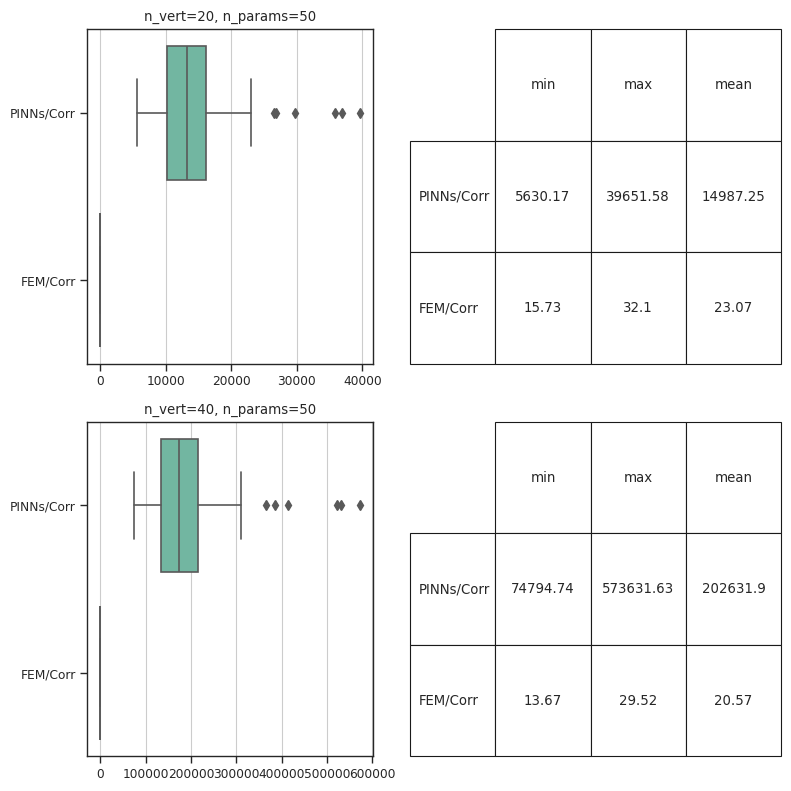

In [18]:
nb_test = len(tab_nb_vert)

plt.figure(figsize=(8,nb_test*4))

for i in range(nb_test):
    plt.subplot(nb_test,2,2*i+1)
    df_facteurs_n_vert = plot_boxplot(i)

    ax = plt.subplot(nb_test,2,2*i+2)
    plot_table(df_facteurs_n_vert,ax)

plt.tight_layout()
plt.savefig(result_dir+f'boxplot_facteurs_case{testcase}_degree{degree}.png')
plt.show()

## Table

In [19]:
def get_df_facteurs_n_vert(i):
    n_vert = tab_nb_vert[i]
    
    # on crée une dataframe contenant les facteurs pour chaque méthode avec n_vert=n_vert
    df_facteurs_n_vert = df_facteurs[[col for col in df_facteurs.columns if col[1] == str(n_vert)]]
    # on supprime la première colonne 
    df_facteurs_n_vert = df_facteurs_n_vert.drop(columns=[df_facteurs_n_vert.columns[0]])
    
    # on change les noms des colonnes
    df_facteurs_n_vert.columns = [col[0] for col in df_facteurs_n_vert.columns]
    
    return df_facteurs_n_vert

def get_values(df_facteurs_n_vert):
    df_min = df_facteurs_n_vert.min(axis=0)
    df_max = df_facteurs_n_vert.max(axis=0)
    df_mean = df_facteurs_n_vert.mean(axis=0)
    df_std = df_facteurs_n_vert.std(axis=0)
    
    return [df_min["PINNs/Corr"],df_max["PINNs/Corr"],df_mean["PINNs/Corr"],df_std["PINNs/Corr"]], \
            [df_min["FEM/Corr"],df_max["FEM/Corr"],df_mean["FEM/Corr"],df_std["FEM/Corr"]]

In [20]:
nb_test = len(tab_nb_vert)

tab_gains_on_PINNs = []
tab_gains_on_FEM = []

for i in range(nb_test):
    df_facteurs_n_vert = get_df_facteurs_n_vert(i)
    gains_on_PINNs,gains_on_FEM = get_values(df_facteurs_n_vert)
    tab_gains_on_PINNs.append(gains_on_PINNs)
    tab_gains_on_FEM.append(gains_on_FEM)
    
tab_gains_on_PINNs = np.array(tab_gains_on_PINNs)
tab_gains_on_FEM = np.array(tab_gains_on_FEM)

columns= ["N","min_PINNs","max_PINNs","mean_PINNs","std_PINNs","min_FEM","max_FEM","mean_FEM","std_FEM"]

df_gains = pd.DataFrame(np.concatenate([np.array(tab_nb_vert).reshape(-1,1),tab_gains_on_PINNs,tab_gains_on_FEM],axis=1),columns=columns)

In [21]:
df_gains

,N,min_PINNs,max_PINNs,mean_PINNs,std_PINNs,min_FEM,max_FEM,mean_FEM,std_FEM
0,20.0,5630.170334,39651.583458,14987.253401,7749.025934,15.734965,32.10484,23.070717,4.361345
1,40.0,74794.739204,573631.630704,202631.902598,113273.243712,13.668617,29.52360,20.568935,4.085161


In [22]:
result_file = result_dir+f'gains_table_case{testcase}_degree{degree}'

df_gains.to_csv(result_file+'.csv')

df_styled = df_gains.style.format("{:.2e}")
dfi.export(df_styled,result_file+".png",dpi=1000)